In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from os.path import join
import skbio
import numpy as np
from collections import Counter
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectPercentile
from sklearn.dummy import DummyClassifier


##Load the mapping file


In [31]:
home = '/home/office-microbe-files'
map_fp = join(home, 'master_map_150908.txt')
sample_md = pd.read_csv(map_fp, sep='\t', index_col=0, dtype=str)
sample_md = sample_md[sample_md['16SITS'] == 'ITS']
sample_md = sample_md[sample_md['OfficeSample'] == 'yes']

In [32]:
replicate_ids = '''F2F.2.Ce.021
F2F.2.Ce.022
F2F.3.Ce.021
F2F.3.Ce.022
F2W.2.Ca.021
F2W.2.Ca.022
F2W.2.Ce.021
F2W.2.Ce.022
F3W.2.Ce.021
F3W.2.Ce.022
F1F.3.Ca.021
F1F.3.Ca.022
F1C.3.Ca.021
F1C.3.Ca.022
F1W.2.Ce.021
F1W.2.Ce.022
F1W.3.Dr.021
F1W.3.Dr.022
F1C.3.Dr.021
F1C.3.Dr.022
F2W.3.Dr.059
F3F.2.Ce.078'''.split('\n')

reps = sample_md[sample_md['Description'].isin(replicate_ids)]
reps = reps.drop(reps.drop_duplicates('Description').index).index
sample_md.drop(reps, inplace=True)

##Load the OTU table


In [33]:
table_fp = '/home/johnchase/office-project/office-microbes/notebooks/UNITE-analysis/core_div/core_div_open/table_even999.txt'
table = pd.read_csv(table_fp, sep='\t', skiprows=1, index_col=0, dtype="object")
table.index = table.index.astype(str)

##Filter table and map to the intersection

In [34]:
ids = set(sample_md.index).intersection(table.columns)
table = table[list(ids)]

#City Machine learning

##Create x and Y vectors
Use feature selection  
Split into test and training sets

In [35]:
y = sample_md.loc[ids]['City'].values
X = table.values.T
X = SelectPercentile().fit_transform(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

/home/johnchase/.conda/envs/da/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   92   655  1485  2906  2969  3035  3161  3344  3447  3587  4279  4831
  5172  5748  6670  7044  7381  8088  8109  8110  8202  8321  8429  8841
  9045  9672 10123 10556 10574 10898 11200 11937 12082 12431 12460 12906
 13482 13524 13793 13840 14069 14103 14134 14227 14351 15042 15061 15150
 15293 15677 15687 15945 16008 16159 16377 17026 17839 17922 18431 18562
 18590 18763 18876 19630 19678 19930 19934 20152 20570 21702 22255 22310
 22431 22465 22558 22750 22799 22944 23491 23495 23657 24211 24334 24664
 24861 25381 25479 25525 25615 25814 25908 25946 26225 27364 27919 27972
 28397 28445 28884 29385 29476 29658 30138 30156 30262 30430 30619 30968
 31094 31410 31480 31522 31615 32096 32326 32333 32403 32524 32687 32705
 32942 33182 33337 34018 34706 34865 35155 35336 35364 35889 35936 36116
 36302 36317 36843 37178 37910 37914 38009 38059 38260 38508 

Run SVC For city. The Parameters were previously defined as being the best using grid search

In [36]:
clf = SVC(C=11, kernel='rbf', gamma=6.3095734448018399e-05, random_state=42)

clf.fit(X_train, y_train)

print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print()

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

  flagstaff       0.57      0.76      0.65       117
   sandiego       0.77      0.41      0.53       105
    toronto       0.54      0.61      0.57        77

avg / total       0.63      0.60      0.59       299




In [37]:
clf_dum = DummyClassifier(strategy='most_frequent')
clf_dum.fit(X_train, y_train)

clf.score(X_test, y_test) /clf_dum.score(X_test, y_test)

1.52991452991453

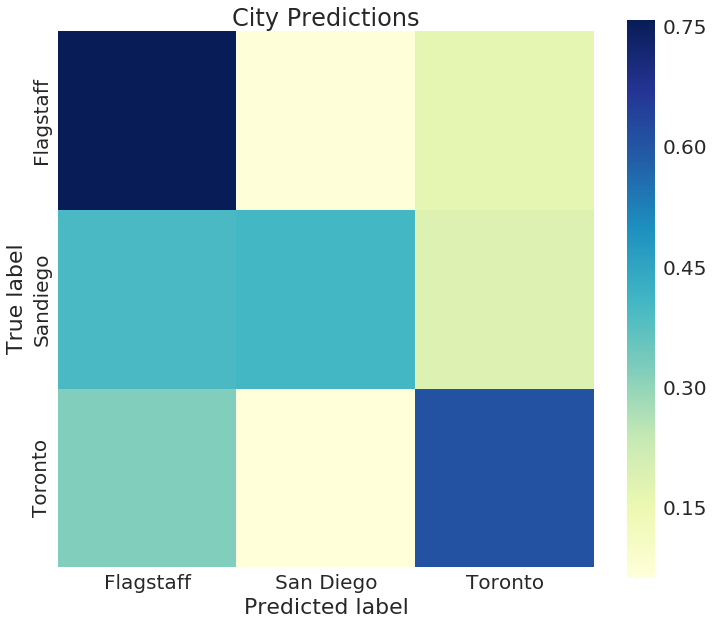

In [38]:
with plt.rc_context(dict(sns.axes_style("darkgrid"),
                         **sns.plotting_context("notebook", font_scale=2))):
    plt.figure(figsize=(12,10))
    cm = confusion_matrix(y_test, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(cm, square=True, cmap="YlGnBu")
    ax.set_xticklabels(['Flagstaff', 'San Diego', 'Toronto'])
    ax.set_yticklabels(['Toronto', 'Sandiego', 'Flagstaff'])
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title('City Predictions')
    plt.savefig('figure-4-city-its.svg', dpi=300)
    

#Office Machine learning

In [39]:
sample_md['CityOffice'] = sample_md['City'] + sample_md['OfficeNumber']

In [40]:
y = sample_md.loc[ids]['CityOffice'].values
X = table.values.T
X = SelectPercentile().fit_transform(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

/home/johnchase/.conda/envs/da/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   92   655  1485  2906  2969  3035  3161  3344  3447  3587  4279  4831
  5172  5748  6670  7044  7381  8088  8109  8110  8202  8321  8429  8841
  9045  9672 10123 10556 10574 10898 11200 11937 12082 12431 12460 12906
 13482 13524 13793 13840 14069 14103 14134 14227 14351 15042 15061 15150
 15293 15677 15687 15945 16008 16159 16377 17026 17839 17922 18431 18562
 18590 18763 18876 19630 19678 19930 19934 20152 20570 21702 22255 22310
 22431 22465 22558 22750 22799 22944 23491 23495 23657 24211 24334 24664
 24861 25381 25479 25525 25615 25814 25908 25946 26225 27364 27919 27972
 28397 28445 28884 29385 29476 29658 30138 30156 30262 30430 30619 30968
 31094 31410 31480 31522 31615 32096 32326 32333 32403 32524 32687 32705
 32942 33182 33337 34018 34706 34865 35155 35336 35364 35889 35936 36116
 36302 36317 36843 37178 37910 37914 38009 38059 38260 38508 

In [41]:
clf = SVC(C=11, gamma=6.3095734448018399e-05, kernel='rbf')

clf.fit(X_train, y_train)

print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print()

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

 flagstaff1       0.57      0.29      0.39        41
 flagstaff2       0.47      0.20      0.28        46
 flagstaff3       0.35      0.37      0.36        30
  sandiego1       0.21      0.65      0.32        40
  sandiego2       0.35      0.26      0.30        31
  sandiego3       0.33      0.09      0.14        34
   toronto1       0.39      0.79      0.52        28
   toronto2       0.50      0.04      0.07        26
   toronto3       0.24      0.17      0.20        23

avg / total       0.39      0.32      0.29       299




In [42]:
clf_dum = DummyClassifier(strategy='most_frequent')
clf_dum.fit(X_train, y_train)

clf.score(X_test, y_test) /clf_dum.score(X_test, y_test)

3.2000000000000002

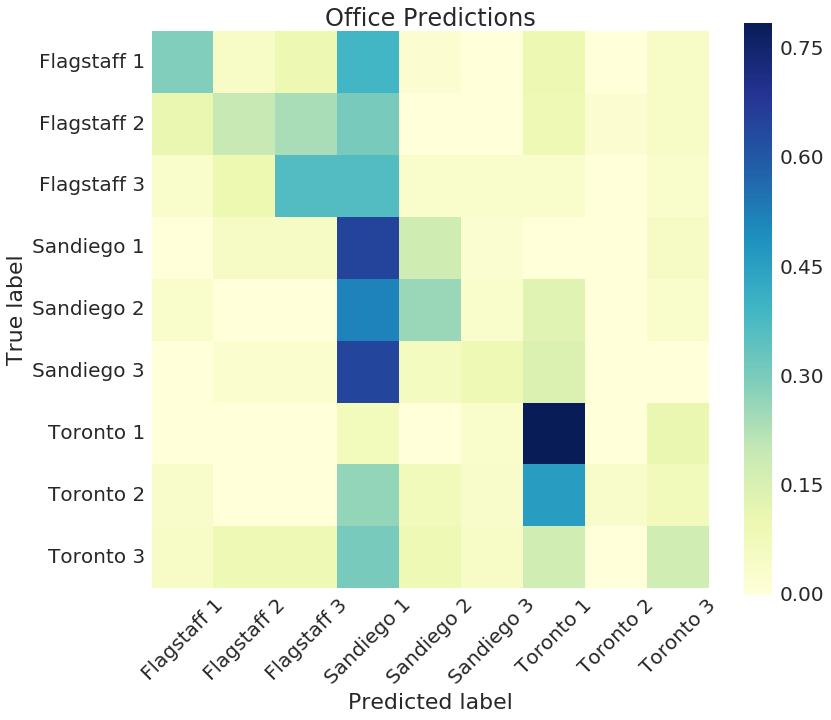

In [43]:
Office_labels = ['Flagstaff 1', 'Flagstaff 2', 'Flagstaff 3', 
                 'Sandiego 1', 'Sandiego 2', 'Sandiego 3',
                 'Toronto 1', 'Toronto 2', 'Toronto 3']

with plt.rc_context(dict(sns.axes_style("darkgrid"),
                         **sns.plotting_context("notebook", font_scale=2))):
    plt.figure(figsize=(12,10))
    cm = confusion_matrix(y_test, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(cm, square=True, cmap="YlGnBu")
    ax.set_xticklabels(Office_labels, rotation=45)
    ax.set_yticklabels(Office_labels[::-1], rotation=0)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title('Office Predictions')
    plt.tight_layout()
    plt.savefig('figure-4-office-its.svg', dpi=300)

##Flagstaff only 

In [44]:
flag_md = sample_md[sample_md['City'] == 'flagstaff']
ids = set(flag_md.index).intersection(table.columns)
y = flag_md.loc[table[list(ids)].columns]['CityOffice'].values
X = table[list(ids)].values.T

In [45]:
X = SelectPercentile().fit_transform(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

/home/johnchase/.conda/envs/da/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    2     3     4 ..., 67482 67484 67485] are constant.
  UserWarning)


In [46]:
clf=SVC(C=11, gamma=6.3095734448018399e-05, kernel='rbf')

clf.fit(X_train, y_train)

print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print()

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

 flagstaff1       0.82      0.37      0.51        38
 flagstaff2       0.54      0.77      0.63        39
 flagstaff3       0.67      0.74      0.71        39

avg / total       0.68      0.63      0.62       116




In [47]:
clf_dum = DummyClassifier(strategy='most_frequent')
clf_dum.fit(X_train, y_train)

clf.score(X_test, y_test) /clf_dum.score(X_test, y_test)

1.8717948717948718

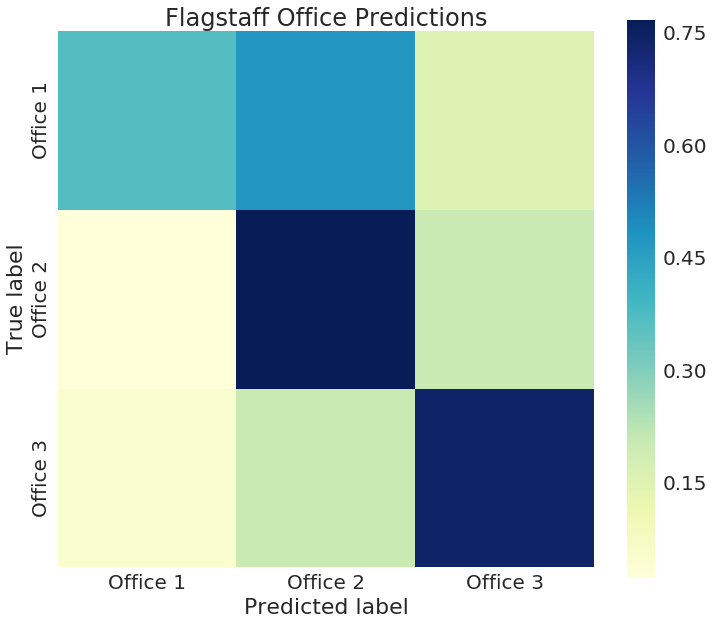

In [48]:
Office_labels = ['1', '2', '3']

with plt.rc_context(dict(sns.axes_style("darkgrid"),
                         **sns.plotting_context("notebook", font_scale=2))):
    plt.figure(figsize=(12,10))
    cm = confusion_matrix(y_test, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(cm, square=True, cmap="YlGnBu")
    ax.set_xticklabels(['Office 1', 'Office 2', 'Office 3'])
    ax.set_yticklabels(['Office 3', 'Office 2', 'Office 1'])
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title('Flagstaff Office Predictions')
    plt.savefig('figure-4-flagstaff-its.svg', dpi=300)

##San Diego

In [49]:
sd_md = sample_md[sample_md['City'] == 'sandiego']
ids = set(sd_md.index).intersection(table.columns)
y = sd_md.loc[table[list(ids)].columns]['CityOffice'].values
X = table[list(ids)].values.T

In [50]:
X = SelectPercentile().fit_transform(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y)

/home/johnchase/.conda/envs/da/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    0     1     2 ..., 67481 67483 67484] are constant.
  UserWarning)


In [51]:
clf = SVC(C=11, gamma=6.3095734448018399e-05, kernel='rbf')

clf.fit(X_train, y_train)

print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print()

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

  sandiego1       0.62      0.86      0.72        44
  sandiego2       0.92      0.34      0.50        35
  sandiego3       0.68      0.81      0.74        26

avg / total       0.74      0.68      0.65       105




In [52]:
clf_dum = DummyClassifier(strategy='most_frequent')
clf_dum.fit(X_train, y_train)

clf.score(X_test, y_test) /clf_dum.score(X_test, y_test)

1.6136363636363638

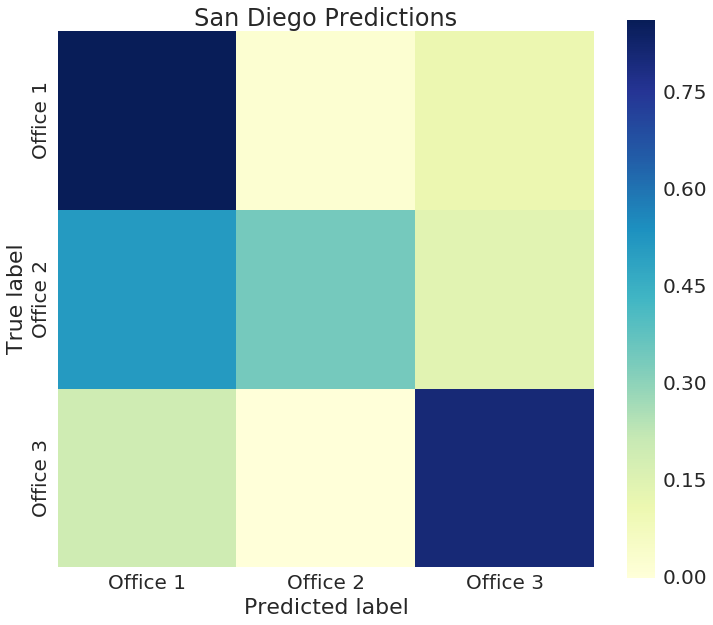

In [53]:
Office_labels = ['1', '2', '3']

with plt.rc_context(dict(sns.axes_style("darkgrid"),
                         **sns.plotting_context("notebook", font_scale=2))):
    plt.figure(figsize=(12,10))
    cm = confusion_matrix(y_test, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(cm, square=True, cmap="YlGnBu")
    ax.set_xticklabels(['Office 1', 'Office 2', 'Office 3'])
    ax.set_yticklabels(['Office 3', 'Office 2', 'Office 1'])
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title('San Diego Predictions')
    plt.savefig('figure-4-sandiego-its.svg', dpi=300)

Toronto
--------

In [54]:
tor_md = sample_md[sample_md['City'] == 'toronto']
ids = set(tor_md.index).intersection(table.columns)
y = tor_md.loc[table[list(ids)].columns]['CityOffice'].values
X = table[list(ids)].values.T

In [55]:
X = SelectPercentile().fit_transform(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y)

/home/johnchase/.conda/envs/da/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    0     1     3 ..., 67481 67482 67485] are constant.
  UserWarning)


In [56]:
clf = SVC(C=11, gamma=6.3095734448018399e-05, kernel='rbf')

clf.fit(X_train, y_train)

print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print()

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

   toronto1       0.52      0.92      0.67        24
   toronto2       0.67      0.07      0.13        27
   toronto3       0.74      0.89      0.81        28

avg / total       0.65      0.62      0.53        79




In [57]:
clf_dum = DummyClassifier(strategy='most_frequent')
clf_dum.fit(X_train, y_train)

clf.score(X_test, y_test) /clf_dum.score(X_test, y_test)

1.75

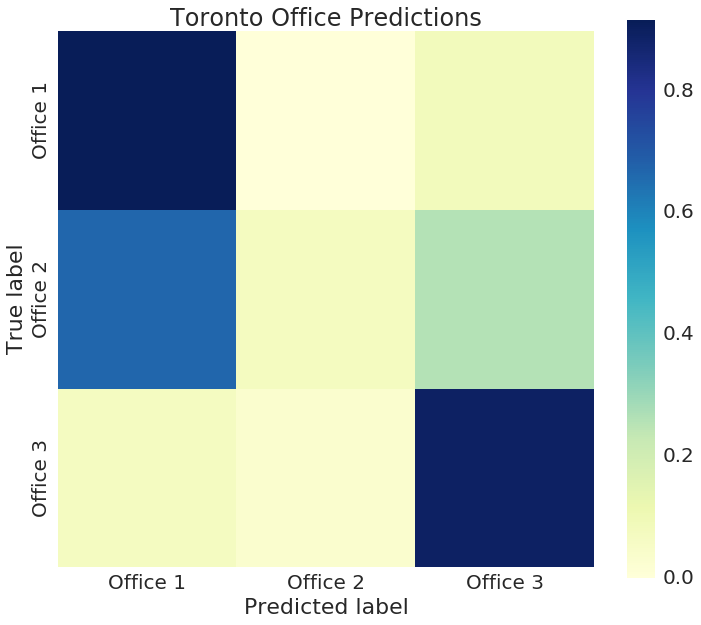

In [58]:
Office_labels = ['1', '2', '3']

with plt.rc_context(dict(sns.axes_style("darkgrid"),
                         **sns.plotting_context("notebook", font_scale=2))):
    plt.figure(figsize=(12,10))
    cm = confusion_matrix(y_test, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(cm, square=True, cmap="YlGnBu")
    ax.set_xticklabels(['Office 1', 'Office 2', 'Office 3'])
    ax.set_yticklabels(['Office 3', 'Office 2', 'Office 1'])
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title('Toronto Office Predictions')
    plt.savefig('figure-4-toronto-its.svg', dpi=300)